Zhuoyuan XU

# Before all

Object detection is a popular domain of DeepLearning. One of famous detection algorithms is YOLO series, its last version is YOLOv5, but in this project we try to implement classic YOLOv3 which was famous as making a big improvement in object detection. The its first version was implemented by different models, and many contributors has analysed this algorithm in detail. Among their work, the explications and codes have trivial differences and errors. This project is to resume these jobs, then realise the Model with commenting the code in detial to understand how does Yolo works.

YOLOv3's input is (1,255,3,3) size 416*416, the pretrained model trains for 80 class, each yolo layer predict 3 anchors, each have 85 values, 4 coordinate+1 score + 80 class proba, 85 $\times$ 3 =255.

Suppose we have three anchors, 80 class, input size = (1, 3, 416,416), after convolution, the input gonna have 3 types, (1, 255, 13, 13), (1, 255, 26, 26), (1, 255, 52, 52), so finally we get (13x13 + 26x26+ 52x52) = 10647 bounding boxes in a size of 416*416, then use NSM to enlever the overlap.

## Configuration file

We use the open source /cfg file in https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch, the [ ] represent its block name.

First block NET is the base parameters of net, when we read the cfg file into net work, remember to skip first block.

In [ ]:
[net]
# Testing
batch=1
subdivisions=1
# Training
# batch=64
# subdivisions=16
width= 320
height = 320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

Downsampling realised by Convolution block followed by shortcut block, -3 is the layer is for skip connection begin from the last 3rd layer.

The yolo block represents the detection layer. Actually each cell's predict result have 3 bounding box, each box have 4 coordonnées of boxes, objective score, class scores. In the yolo block, mask is 1, 2, 3, means it will use the 1st, 2nd and 3rd anchors. 

In [ ]:
# Downsample
[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

...
...
...

[yolo]
mask = 0,1,2
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=80
num=9
jitter=.3
ignore_thresh = .5
truth_thresh = 1
random=1


darknet.py

## construct net

First we parse the cfg file. load the text in to blocks

In [2]:
import torch
import torch.nn as nn

def parse_cfg(cfgfile):

    # read cfg file
    with open(cfgfile, 'r') as f:
        lines = f.read().split('\n')
    lines = [x for x in lines if len(x) > 0] # enlever blanc line
    lines = [x for x in lines if x[0]!='#'] # enlever # line
    lines = [x.rstrip().lstrip() for x in lines] # enlever left right blanc 

    block = {}
    blocks = []

    for line in lines:
        if line[0] == "[":  
            if len(block) != 0: 
                blocks.append(block)
                block = {} 
            block["type"] = line[1:-1].rstrip()  # name of block
        else:
            key, value = line.split("=")
            block[key.rstrip()] = value.lstrip()
    blocks.append(block) 

    # print('\n\n'.join([repr(x) for x in blocks])) # if we want to see the result
    return blocks

cfg = parse_cfg("cfg/yolov3.cfg")
cfg

[{'angle': '0',
  'batch': '1',
  'burn_in': '1000',
  'channels': '3',
  'decay': '0.0005',
  'exposure': '1.5',
  'height': '320',
  'hue': '.1',
  'learning_rate': '0.001',
  'max_batches': '500200',
  'momentum': '0.9',
  'policy': 'steps',
  'saturation': '1.5',
  'scales': '.1,.1',
  'steps': '400000,450000',
  'subdivisions': '1',
  'type': 'net',
  'width': '320'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '32',
  'pad': '1',
  'size': '3',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '64',
  'pad': '1',
  'size': '3',
  'stride': '2',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '32',
  'pad': '1',
  'size': '1',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '64',
  'pad': '1',
  'size': '3',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'linear', 'from': '-3', 'type': 

In [4]:
class EmptyLayer(nn.Module):
    """
    The empty layer works for shortcut layer / route layer for easy connect, used in forward part
    """
    def __init__(self):
        super(EmptyLayer, self).__init__()

class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

    def forward(self, x, input_dim, num_classes, confidence):
        x = x.data
        global CUDA
        prediction = x
        prediction = predict_transform(prediction, input_dim, self.anchors, num_classes, confidence, CUDA)

        return prediction

def create_modules(blocks):
    # get the input net and parameters
    net_info = blocks[0]

    module_list = nn.ModuleList()
    index = 0 # use for route layer 
    previous_filters = 3 
    output_filters = []

    for block in blocks:
        container = nn.Sequential()
        if block["type"] == "net":
            continue

        if block["type"] == "convolutional":
            ''' 1. Cov layer '''
            # get the activation function
            activation = block["activation"]
            try:
                batch_normalize = int(block["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
            filters = int(block["filters"])
            padding = int(block["pad"])
            kernel_size = int(block["size"])
            stride = int(block["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            # Add the convolutional layer
            # nn.Conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)
            conv = nn.Conv2d(previous_filters, filters, kernel_size, stride, pad, bias=bias)
            container.add_module("conv_{0}".format(index), conv)

            # Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                container.add_module("batch_norm_{0}".format(index), bn)

            # Check the activation.
            # Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace=True)
                container.add_module("leaky_{0}".format(index), activn)

        elif block["type"] == "upsample":
            '''
            2. upsampling layer
            pas utilise Bilinear2dUpsampling
            use nearest 
            '''
            upsample = nn.Upsample(scale_factor=2, mode="nearest")
            container.add_module("upsample_{}".format(index), upsample)

        # route layer -> Empty layer
        elif block["type"] == "route":
            block["layers"] = block["layers"].split(',')

            #Start  of a route
            start = int(block["layers"][0])
            #end, if there exists one.
            try:
                end = int(block["layers"][1])
            except:
                end = 0

            #Positive
            if start > 0:
                start = start - index

            if end > 0:
                end = end - index

            route = EmptyLayer()
            container.add_module("route_{0}".format(index), route)

            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]

        # shortcut corresponds to skip connection
        elif block["type"] == "shortcut":
            from_ = int(block["from"])
            shortcut = EmptyLayer()
            container.add_module("shortcut_{}".format(index), shortcut)

        elif block["type"] == "maxpool":
            stride = int(block["stride"])
            size = int(block["size"])
            maxpool = nn.MaxPool2d(size, stride)
            container.add_module("maxpool_{}".format(index), maxpool)

        # the detection layer
        elif block["type"] == "yolo":
            mask = block["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = block["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors) # anchor detection test classify
            container.add_module("Detection_{}".format(index), detection)
        else:
            print("...咱未实现的...")
            assert False

        module_list.append(container)
        previous_filters = filters
        output_filters.append(filters)
        index += 1

    return net_info, module_list

blocks = parse_cfg('cfg/yolov3.cfg')
x,y = create_modules(blocks)
print(y)

ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): Sequential(
    (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

Now we can connect our block to net.

In [5]:
import numpy as np


def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA=True):
    """
    in every point of grid there are 3 anchors
    """
    batch_size = prediction.size(0)
    stride = inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)

    anchors = [(a[0] / stride, a[1] / stride) for a in anchors]

    prediction = prediction.view(batch_size, bbox_attrs * num_anchors, grid_size * grid_size)
    prediction = prediction.transpose(1, 2).contiguous()
    prediction = prediction.view(batch_size, grid_size * grid_size * num_anchors, bbox_attrs)

    # Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:, :, 0] = torch.sigmoid(prediction[:, :, 0])
    prediction[:, :, 1] = torch.sigmoid(prediction[:, :, 1])
    prediction[:, :, 4] = torch.sigmoid(prediction[:, :, 4])

    # Add the center offsets
    grid_len = np.arange(grid_size)
    a, b = np.meshgrid(grid_len, grid_len)

    x_offset = torch.FloatTensor(a).view(-1, 1)
    y_offset = torch.FloatTensor(b).view(-1, 1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1, num_anchors).view(-1, 2).unsqueeze(0)

    prediction[:, :, :2] += x_y_offset

    # log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size * grid_size, 1).unsqueeze(0)
    prediction[:, :, 2:4] = torch.exp(prediction[:, :, 2:4]) * anchors

    # Softmax the class scores
    prediction[:, :, 5: 5 + num_classes] = torch.sigmoid((prediction[:, :, 5: 5 + num_classes]))

    prediction[:, :, :4] *= stride

    return prediction


class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        self.header = torch.IntTensor([0, 0, 0, 0])
        self.seen = 0

    def get_blocks(self):
        return self.blocks # list

    def get_module_list(self):
        return self.module_list # nn.ModuleList

    def forward(self, x, CUDA=True):
        detections = []
        # skip the first net block
        modules = self.blocks[1:]

        # cache output for route layer
        outputs = {}

        write = False 
        for i in range(len(modules)):
            module_type = modules[i]["type"]

            #
            if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
                x = self.module_list[i](x)
                outputs[i] = x
            #
            elif module_type == "route":
                layers = modules[i]["layers"]
                layers = [int(a) for a in layers]

                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]

                    x = torch.cat((map1, map2), 1)
                outputs[i] = x

            elif module_type == "shortcut":
                from_ = int(modules[i]["from"])
                x = outputs[i - 1] + outputs[i + from_]  # sum
                outputs[i] = x

            #
            elif module_type == 'yolo':

                anchors = self.module_list[i][0].anchors
                # Get the input dimensions
                inp_dim = int(self.net_info["height"])

                # Get the number of classes
                num_classes = int(modules[i]["classes"])

                # Output the result
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)

                if type(x) == int:
                    continue

                # display in 3 level 
                # save in detections
                if not write:
                    detections = x
                    write = True

                else:
                    detections = torch.cat((detections, x), 1)

                outputs[i] = outputs[i - 1]
        # finish forward
        try:
            return detections
        except:
            return 0
    def load_weights(self, weightfile):

        # Open the weights file
        fp = open(weightfile, "rb")
      
        header = np.fromfile(fp, dtype=np.int32, count=5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]

        # The rest of the values are the weights
        # load them up
        weights = np.fromfile(fp, dtype=np.float32)

        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]

            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i + 1]["batch_normalize"])
                except:
                    batch_normalize = 0

                conv = model[0]

                if (batch_normalize):
                    bn = model[1]

                    # Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()

                    # Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr += num_bn_biases

                    # Cast the loaded weights into dims of model weights.
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    # Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)

                else:
                    # Number of biases
                    num_biases = conv.bias.numel()

                    # Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases

                    # reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)

                    # Finally copy the data
                    conv.bias.data.copy_(conv_biases)

                # Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()

                # Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr + num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)


model = Darknet("cfg/yolov3.cfg")
input = torch.sigmoid(torch.rand(1, 3, 416, 416).float())
model.net_info["height"] = 416
predictions = model(input, False)
print(predictions.shape) # torch.Size([1, 10647, 85]) 

torch.Size([1, 10647, 85])


## NMS 

In [6]:
def write_results(predictions, confidence, num_class, nms=True, nms_thresh=0.4):
    # keep ones over confidence
    # confidence: shape=(1,10647, 85)
    # mask: shape=(1,10647) => (1, 10647, 1)
    mask = (predictions[:, :, 4] > confidence).float().unsqueeze(2)
    predictions = predictions*mask # under confidence become 0

    # if not effective result, return 0
    ind_nz = torch.nonzero(predictions[:, :, 4].squeeze()).squeeze()
    if ind_nz.size(0) == 0:
        return 0
    # predictions = predictions[:, ind_nz, :]

    '''
    keep box over confidence
    '''

    # prediction 5 first value (Cx, Cy, w, h, score)
    bbox = predictions.new(predictions.shape)
    bbox[:, :, 0] = (predictions[:, :, 0] - predictions[:, :, 2]/2) # x1 = Cx - w/2
    bbox[:, :, 1] = (predictions[:, :, 1] - predictions[:, :, 3]/2) # y1 = Cy - h/2
    bbox[:, :, 2] = (predictions[:, :, 0] + predictions[:, :, 2]/2) # x2 = Cx + w/2
    bbox[:, :, 3] = (predictions[:, :, 1] + predictions[:, :, 3]/2) # y2 = Cy + h/2
    predictions[:, :, :4] = bbox[:, :, :4] 

    batch_size = predictions.size(0) # dim=0
    output = predictions.new(1, predictions.size(2)+1) # shape=(1,85+1)

    write = False 
    for ind in range(batch_size):
       
        prediction = predictions[ind]
        
        ind_nz = torch.nonzero(prediction[:, 4].squeeze()).squeeze()
        if ind_nz.size(0) == 0:
            continue
        prediction = prediction[ind_nz, :]
        # print(prediction.shape) # shape=(10647->14, 85)

        max_score, max_score_ind = torch.max(prediction[:, 5:], 1) # prediction[:, 5:] score of each class

        # max_score: shape=(10647->14) => (10647->14,1)
        max_score = max_score.float().unsqueeze(1)
        max_score_ind = max_score_ind.float().unsqueeze(1)
        seq = (prediction[:, :5], max_score, max_score_ind) # first 5
        prediction = torch.cat(seq, 1) # shape=(10647, 5+1+1=7)
        # print(prediction.shape)


        # get the classes
        try:
            image_classes = unique(prediction[:, -1]) # tensor, shape=(n)
        except:
            continue

        # NMS
        for cls in image_classes:
  
            # -1: cls_index, -2: score
            class_mask = (prediction[:, -1] == cls) # shape=(n)
            class_mask_ind = torch.nonzero(class_mask).squeeze() # shape=(n,1) => (n)

            # prediction_: shape(n,7)
            prediction_class = prediction[class_mask_ind].view(-1, 7) # 


            #  nms
            # sort score
            # big on the top
            score_sort_ind = torch.sort(prediction_class[:, 4], descending=True)[1] 
            prediction_class = prediction_class[score_sort_ind]
            cnt = prediction_class.size(0) # 个数

            if nms:
                for i in range(cnt):

                    try:
                        ious = bbox_iou(prediction_class[i].unsqueeze(0), prediction_class[i+1:])
                    except ValueError:
                        break
                    except IndexError:
                        break

                    iou_mask = (ious < nms_thresh).float().unsqueeze(1)
                    prediction_class[i+1:] *= iou_mask # keep i
                   
                    non_zero_ind = torch.nonzero(prediction_class[:, 4].squeeze())
                    prediction_class = prediction_class[non_zero_ind].view(-1, 7)

                    # iou_mask = (ious < nms_thresh).float() # shape=(n)
                    # non_zero_ind = torch.nonzero(iou_mask).squeeze()+1 
                    # prediction_class = prediction_class[non_zero_ind].view(-1, 7)

            # save result
            batch_ind = prediction_class.new(prediction_class.size(0), 1).fill_(ind)
            seq = batch_ind, prediction_class

            if  not write:
                output = torch.cat(seq, 1)
                write = True
            else:
                out = torch.cat(seq, 1)
                output = torch.cat((output, out))

    return output

## Preprocess

In [7]:
import cv2 
def letterbox_image(img, input_dim):
    """
    reshape long and short side
    """
    ori_w, ori_h = img.shape[1], img.shape[0]
    dst_w, dst_h = input_dim
    new_w = int(ori_w * min(dst_w/ori_w, dst_h/ori_h)) 
    new_h = int(ori_h * min(dst_w/ori_w, dst_h/ori_h))
    resized_image = cv2.resize(src=img, dsize=(new_w, new_h), interpolation=cv2.INTER_CUBIC) 

    # move the img to ceter of canvas
    canvas = np.full(shape=(dst_w, dst_h, 3), fill_value=128)
    canvas[(dst_h-new_h)//2: (dst_h-new_h)//2 + new_h, (dst_w-new_w)//2: (dst_w-new_w)//2 + new_w, :] = resized_image

    return canvas



def preprocess_image(img, input_dim):
    """
    para：path, dimension 
    resize to inp_dim*inp_dim
    (3，416,416)
    """
    ori_img = cv2.imread(img)
    dim = ori_img.shape[1], ori_img.shape[0] # h,w, c
    img = letterbox_image(ori_img, (input_dim, input_dim))
    # img = letterbox_image_(ori_img, (input_dim, input_dim))
    img_ = img[:, :, ::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, ori_img, dim
  

## detector

We defined the net, the tools, using the coco.names of the coco 80 class and the pretrained weight, we are already near the end, it is left the detetor. 

https://pjreddie.com/media/files/yolov3.weights 

In [8]:
def load_classes(namesfile):
    """
    :param namesfile:
    """
    with open(namesfile, 'r') as f:
        names = f.read().split("\n")[:-1] 
        return len(names), names

In [ ]:
from __future__ import division
import time
from torch.autograd import Variable
import cv2
import argparse
import os
import os.path as osp
import pandas as pd
import random
import pickle as pkl
import itertools

images = './img' # image path
dets = './det' # result path
scales = '1, 2, 3'
batch_size = 1
confidence = 0.5
nms_thresh = 0.4

# GPU
CUDA = torch.cuda.is_available()

# coco
num_class, classes = load_classes("coco.names")

# begins
print("begin loading")
model = Darknet("cfg/yolov3.cfg")
model.load_weights('yolov3.weights')
print("loading finish.")

# input size
model.net_info["height"] = int(416)
input_dim = model.net_info["height"]
assert input_dim > 0 and input_dim % 32 == 0

# to GPU if possible
if CUDA:
    model.cuda()
# eval
model.eval()

# imagrs to detect
try:
    imlist = [os.path.join(images, img) for img in os.listdir(images) if os.path.splitext(img)[1] in [".png", ".jpg", ".jpeg"]]
except NotADirectoryError:
    imlist = []
    imlist.append(os.path.join(images))
except FileNotFoundError:
    print("%s no file" % (images,))
    exit()

# result dict
if not os.path.exists(dets):
    os.mkdir(dets)

load_batch = time.time()
# load image
# map: prep_image,  imlist [input_dim for x in imlist] 
batches = list(map(preprocess_image, imlist, [input_dim for x in imlist]))
ptt_images = [x[0] for x in batches] # ptt: pytorch_tensor
ori_images = [x[1] for x in batches]
ori_images_dim_list = [x[2] for x in batches]
# repeat(*size)
# 注: size
ori_images_dim_list = torch.FloatTensor(ori_images_dim_list).repeat(1, 2) # (11,4) 

if CUDA:
    ori_images_dim_list = ori_images_dim_list.cuda()

# objs = []

i = 0
#  批处理 ...
write = False
if batch_size>1:
    num_batches = int(len(imlist)/batch_size + 0.5)
    ptt_images = [torch.cat(
                    (ptt_images[ i * batch_size: min((i + 1) * batch_size, len(ptt_images)) ]) )
                  for i in range(num_batches)]


for batch in ptt_images:
    start = time.time()
    if CUDA:
        batch = batch.cuda()

    with torch.no_grad():
        predictions = model(Variable(batch), CUDA)
    # 结果过滤
    predictions = write_results(predictions, confidence, num_class, nms=True, nms_thresh=nms_thresh)

    if type(predictions) == int:
        i += 1
        continue
    end = time.time()

    print(end - start, predictions.shape) # 单位 秒

    predictions[:, 0] += i * batch_size # [0]表示图像索引

    if  not write:
        output = predictions
        write = True
    else:
        output = torch.cat((output, predictions))

    for im_num, image in enumerate(imlist[i*batch_size: min((i+1)*batch_size, len(imlist))]):
        im_ind =  i*batch_size + im_num # No of image 
        objs = [ classes[int(x[-1])] for x in output if int(x[0]) == im_ind] #im_ind image
        print("{0:20s} predicted in {1:6.3f} seconds".format(osp.split(image)[-1], (end-start)/batch_size))
        print("----------------------------------------------------------")
    i += 1


# 对所有的输入的检测结果
try:
    output
except:
    print("没有检测到任何目标")
    exit()

# 0: 图像索引 1-4： 坐标(在缩放后图像中的位置) 5：score 6： ？？？ 7（-1）：类别
# print(output)

# 对output结果按照dim=0维度分组？
ori_images_dim_list = torch.index_select(ori_images_dim_list, 0, output[:, 0].long()) # pytorch 切片torch.index_select(data, dim, indices)
scaling_factor = torch.min(input_dim/ori_images_dim_list, 1)[0].view(-1, 1)

# 坐标换算,将居中的位置坐标转换为以(0,0)为起点的坐标 x-x'soffset, y-y'soffset
output[:, [1,3]] -= (input_dim - scaling_factor*ori_images_dim_list[:, 0].view(-1,1))/2 # x416 - (缩放后x<=416长度/2 )
output[:, [2,4]] -= (input_dim - scaling_factor*ori_images_dim_list[:, 1].view(-1,1))/2

output[:, 1:5] /= scaling_factor # 缩放至原图大小尺寸

# 绘图
colors = pkl.load(open("pallete", "rb"))
def draw(x, batch, results):
    # batch 转换后的图像， 没用到这里
    c1 = tuple(x[1:3].int()) # x1,y1
    c2 = tuple(x[3:5].int()) # x2,y2
    img = results[int(x[0])] # 图像索引
    cls = int(x[-1])
    label = "%s" % classes[cls]
    color = random.choice(colors) # 随机选择颜色
    # 绘图（绘制一条结果）
    cv2.rectangle(img, c1, c2, color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225, 255, 255], 1)
    return img
# draw result
l = list(map(lambda x: draw(x, ptt_images, ori_images), output))
# save path
det_names = ["{}/det_{}".format('/det', osp.split(x)[-1]) for x in imlist]
it = list(map(cv2.imwrite, det_names, ori_images))

## Result

So far, we have talked about the YOLOv3, now let's try an example. Let's use the President Macron's photo published on 29 April 2021 on the site https://www.lamontagne.fr/paris-75000/actualites/deconfinement-pour-emmanuel-macron-la-france-et-les-francais-doivent-respirer_13947018/. We can see that with the pretained 80 class model, we. can detect person, bottle, cup and tie in the image.

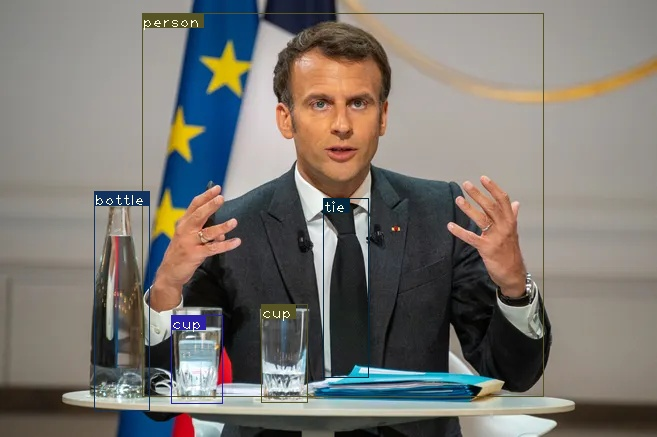

In [10]:
from IPython.display import Image
Image('det/det_macron.jpg')

For the performance of model, I strongly suggest go to:
https://colab.research.google.com/github/ultralytics/yolov3/blob/master/tutorial.ipynb, which also have visualisation in wandb.ai.




Here we test its performance for train coco128, with  --epochs == 50, we can check its continual decline in loss.

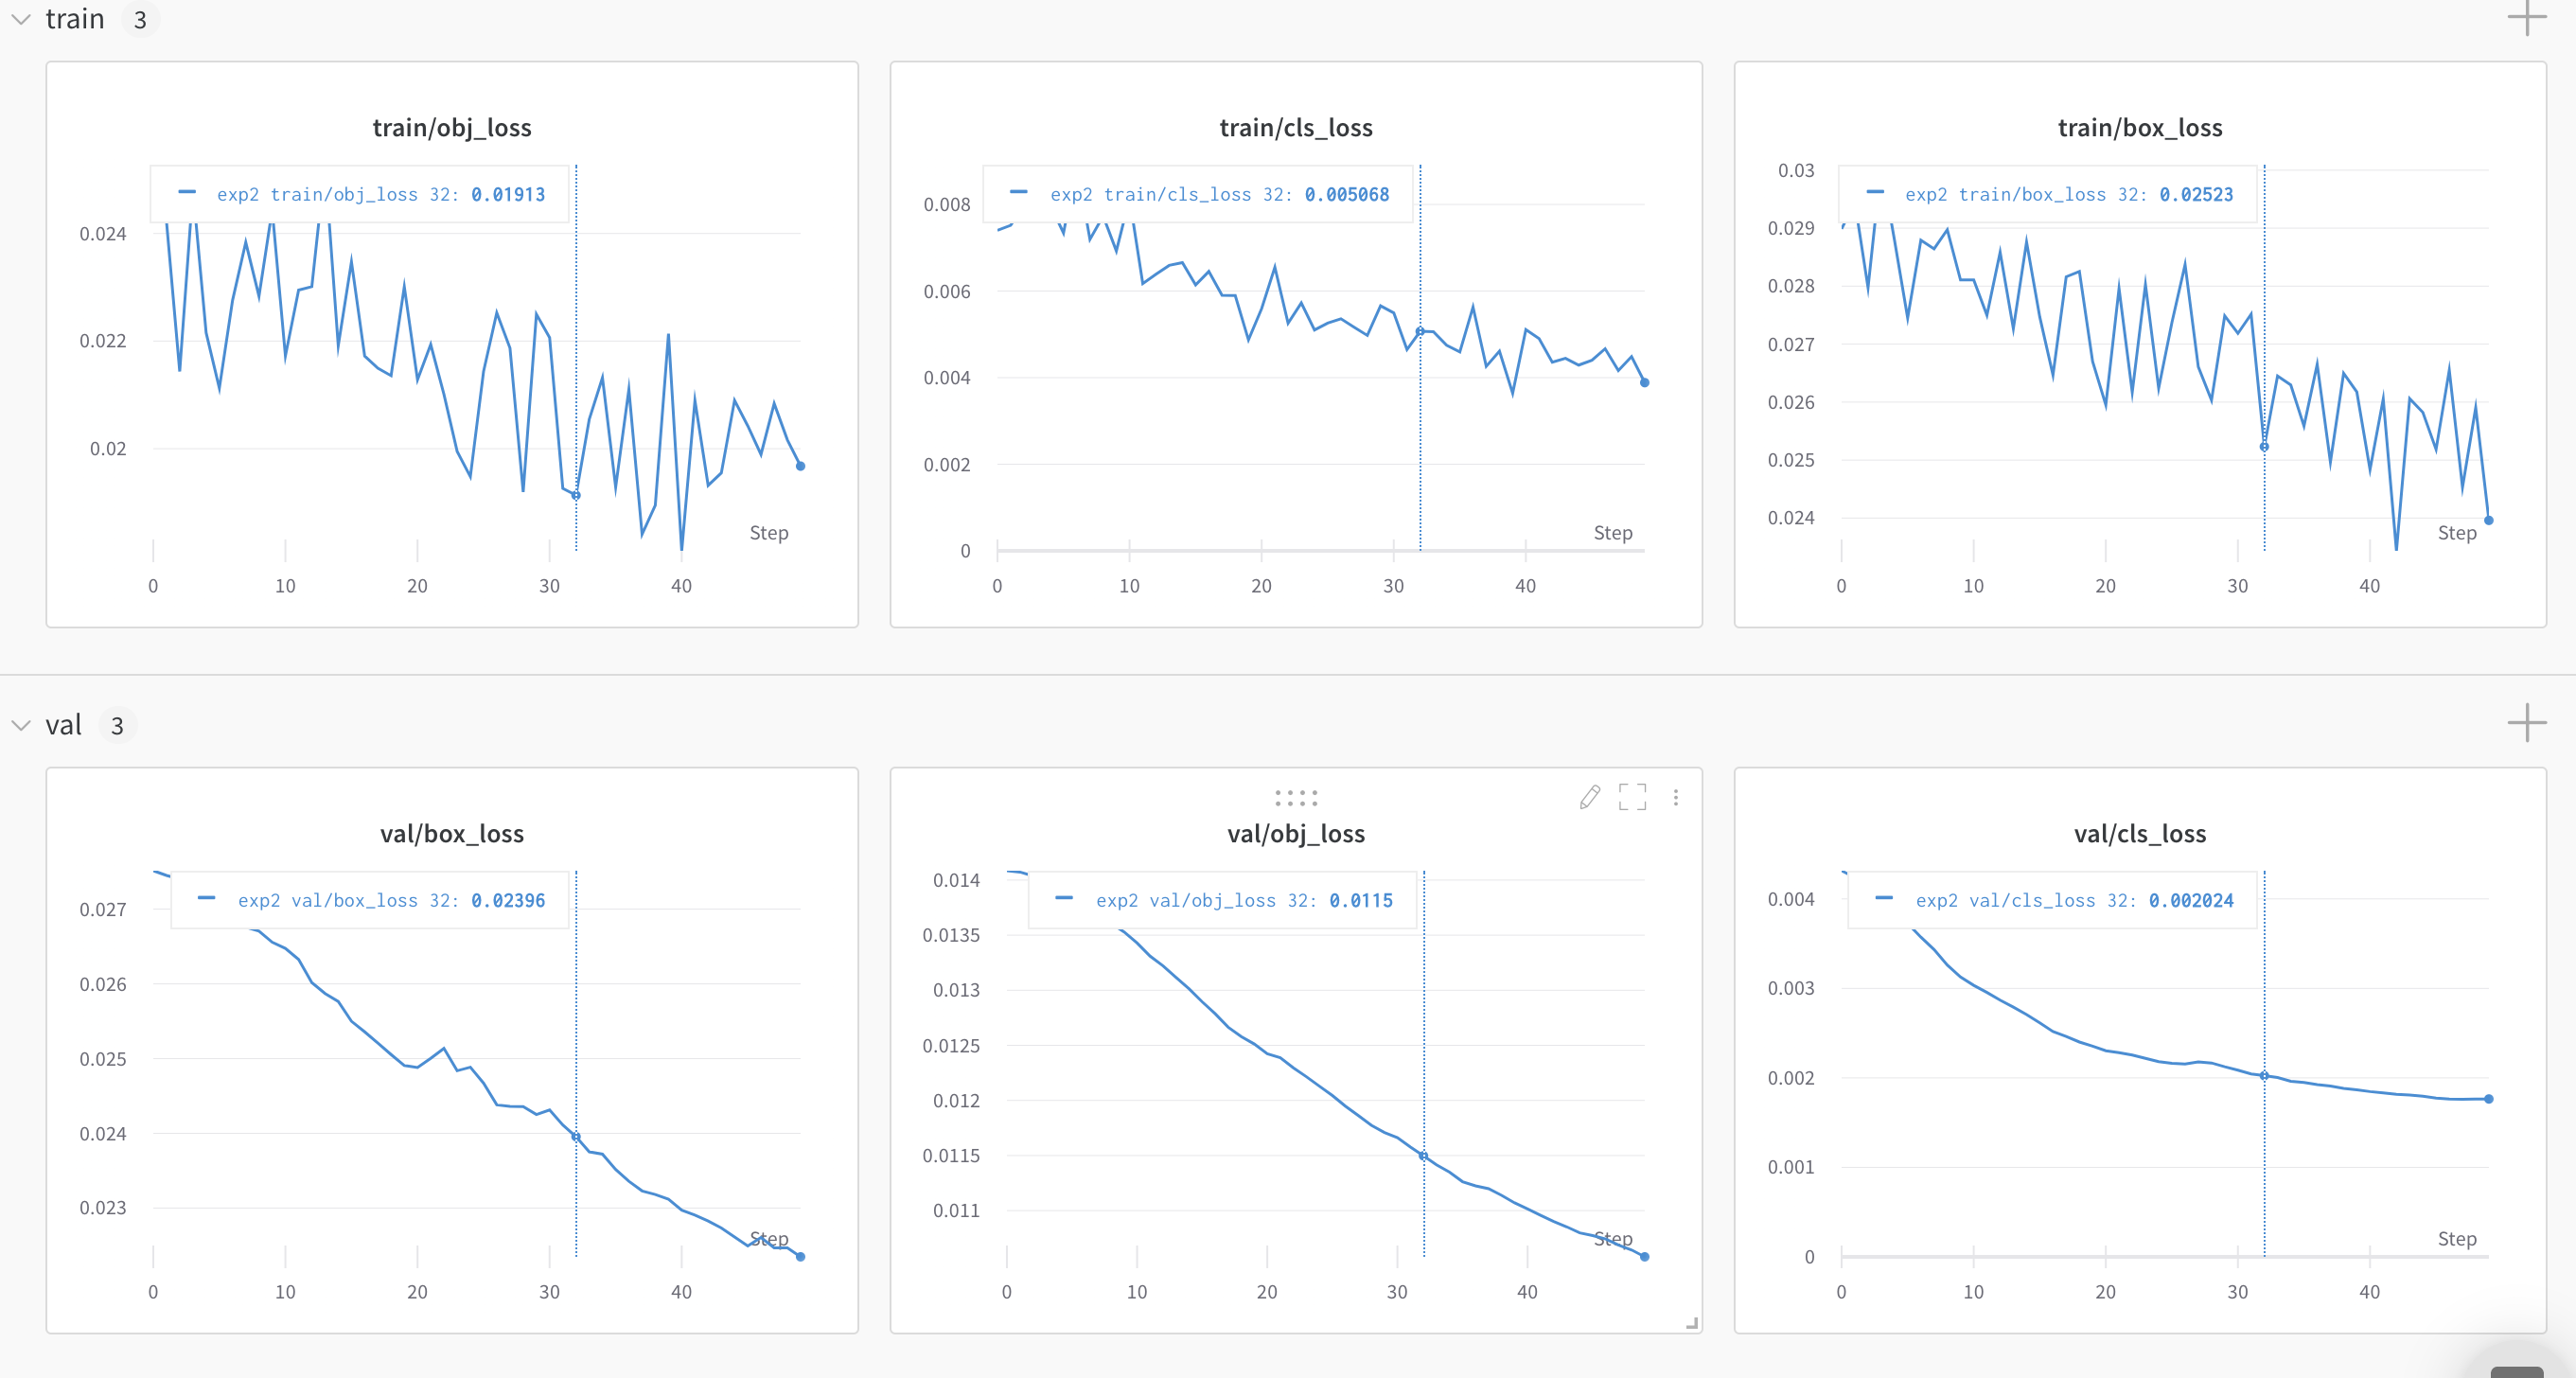

In [11]:
Image('Yolo v3_50.png')

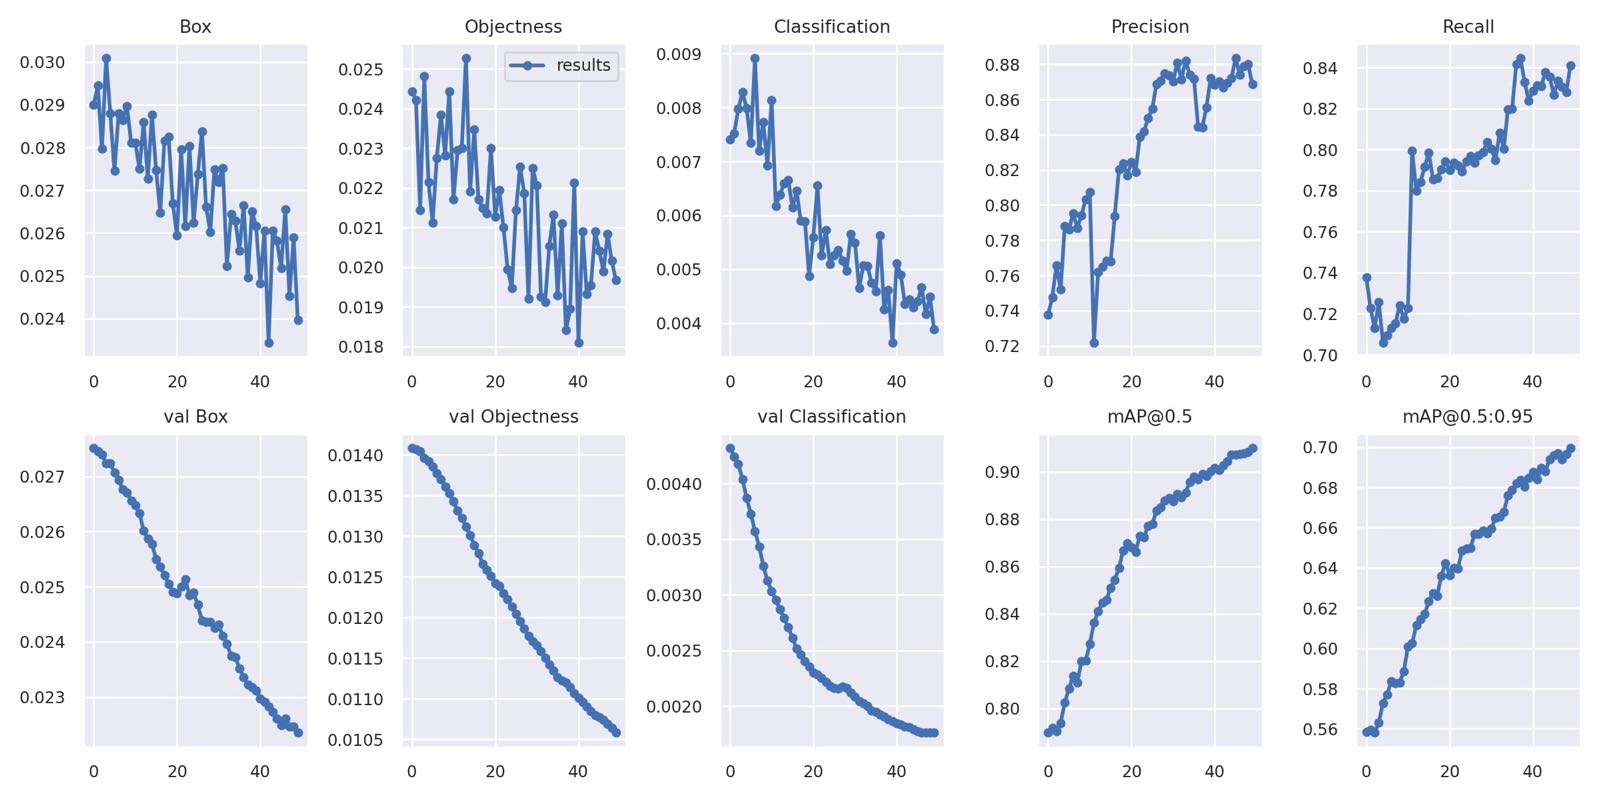

In [14]:
Image('res128.jpg')

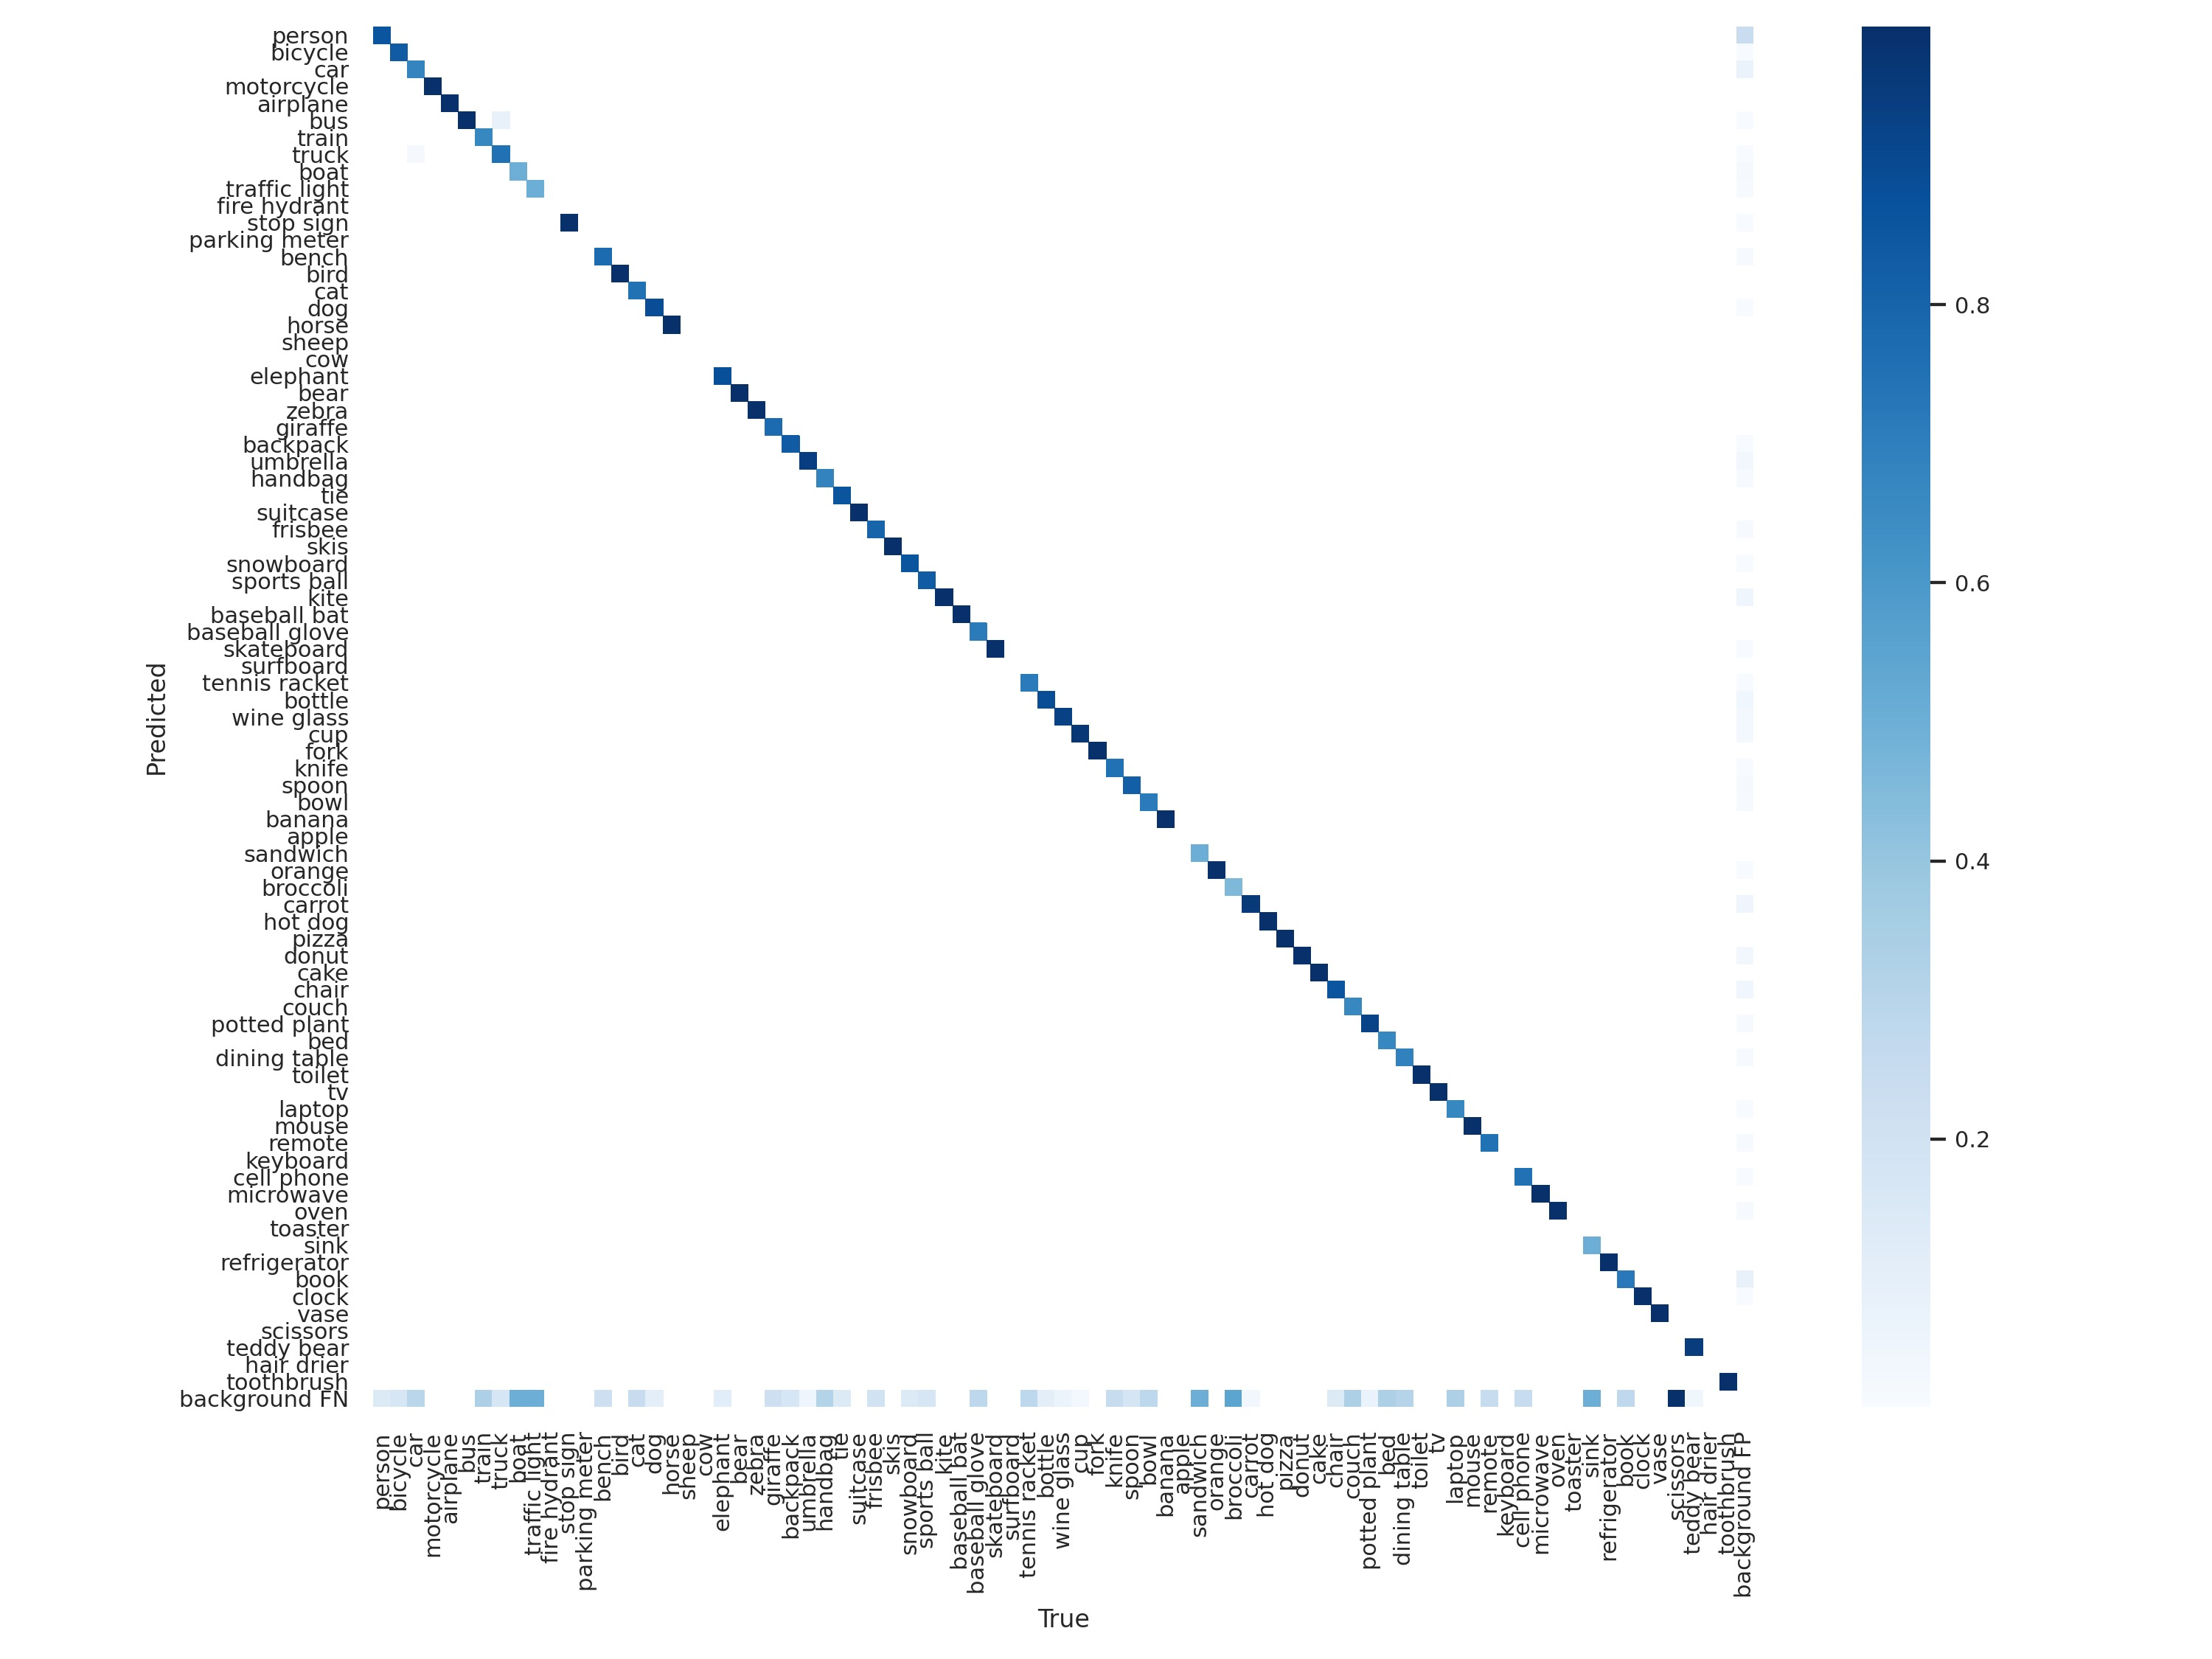

In [13]:
Image('confusionmatrix.jpg')

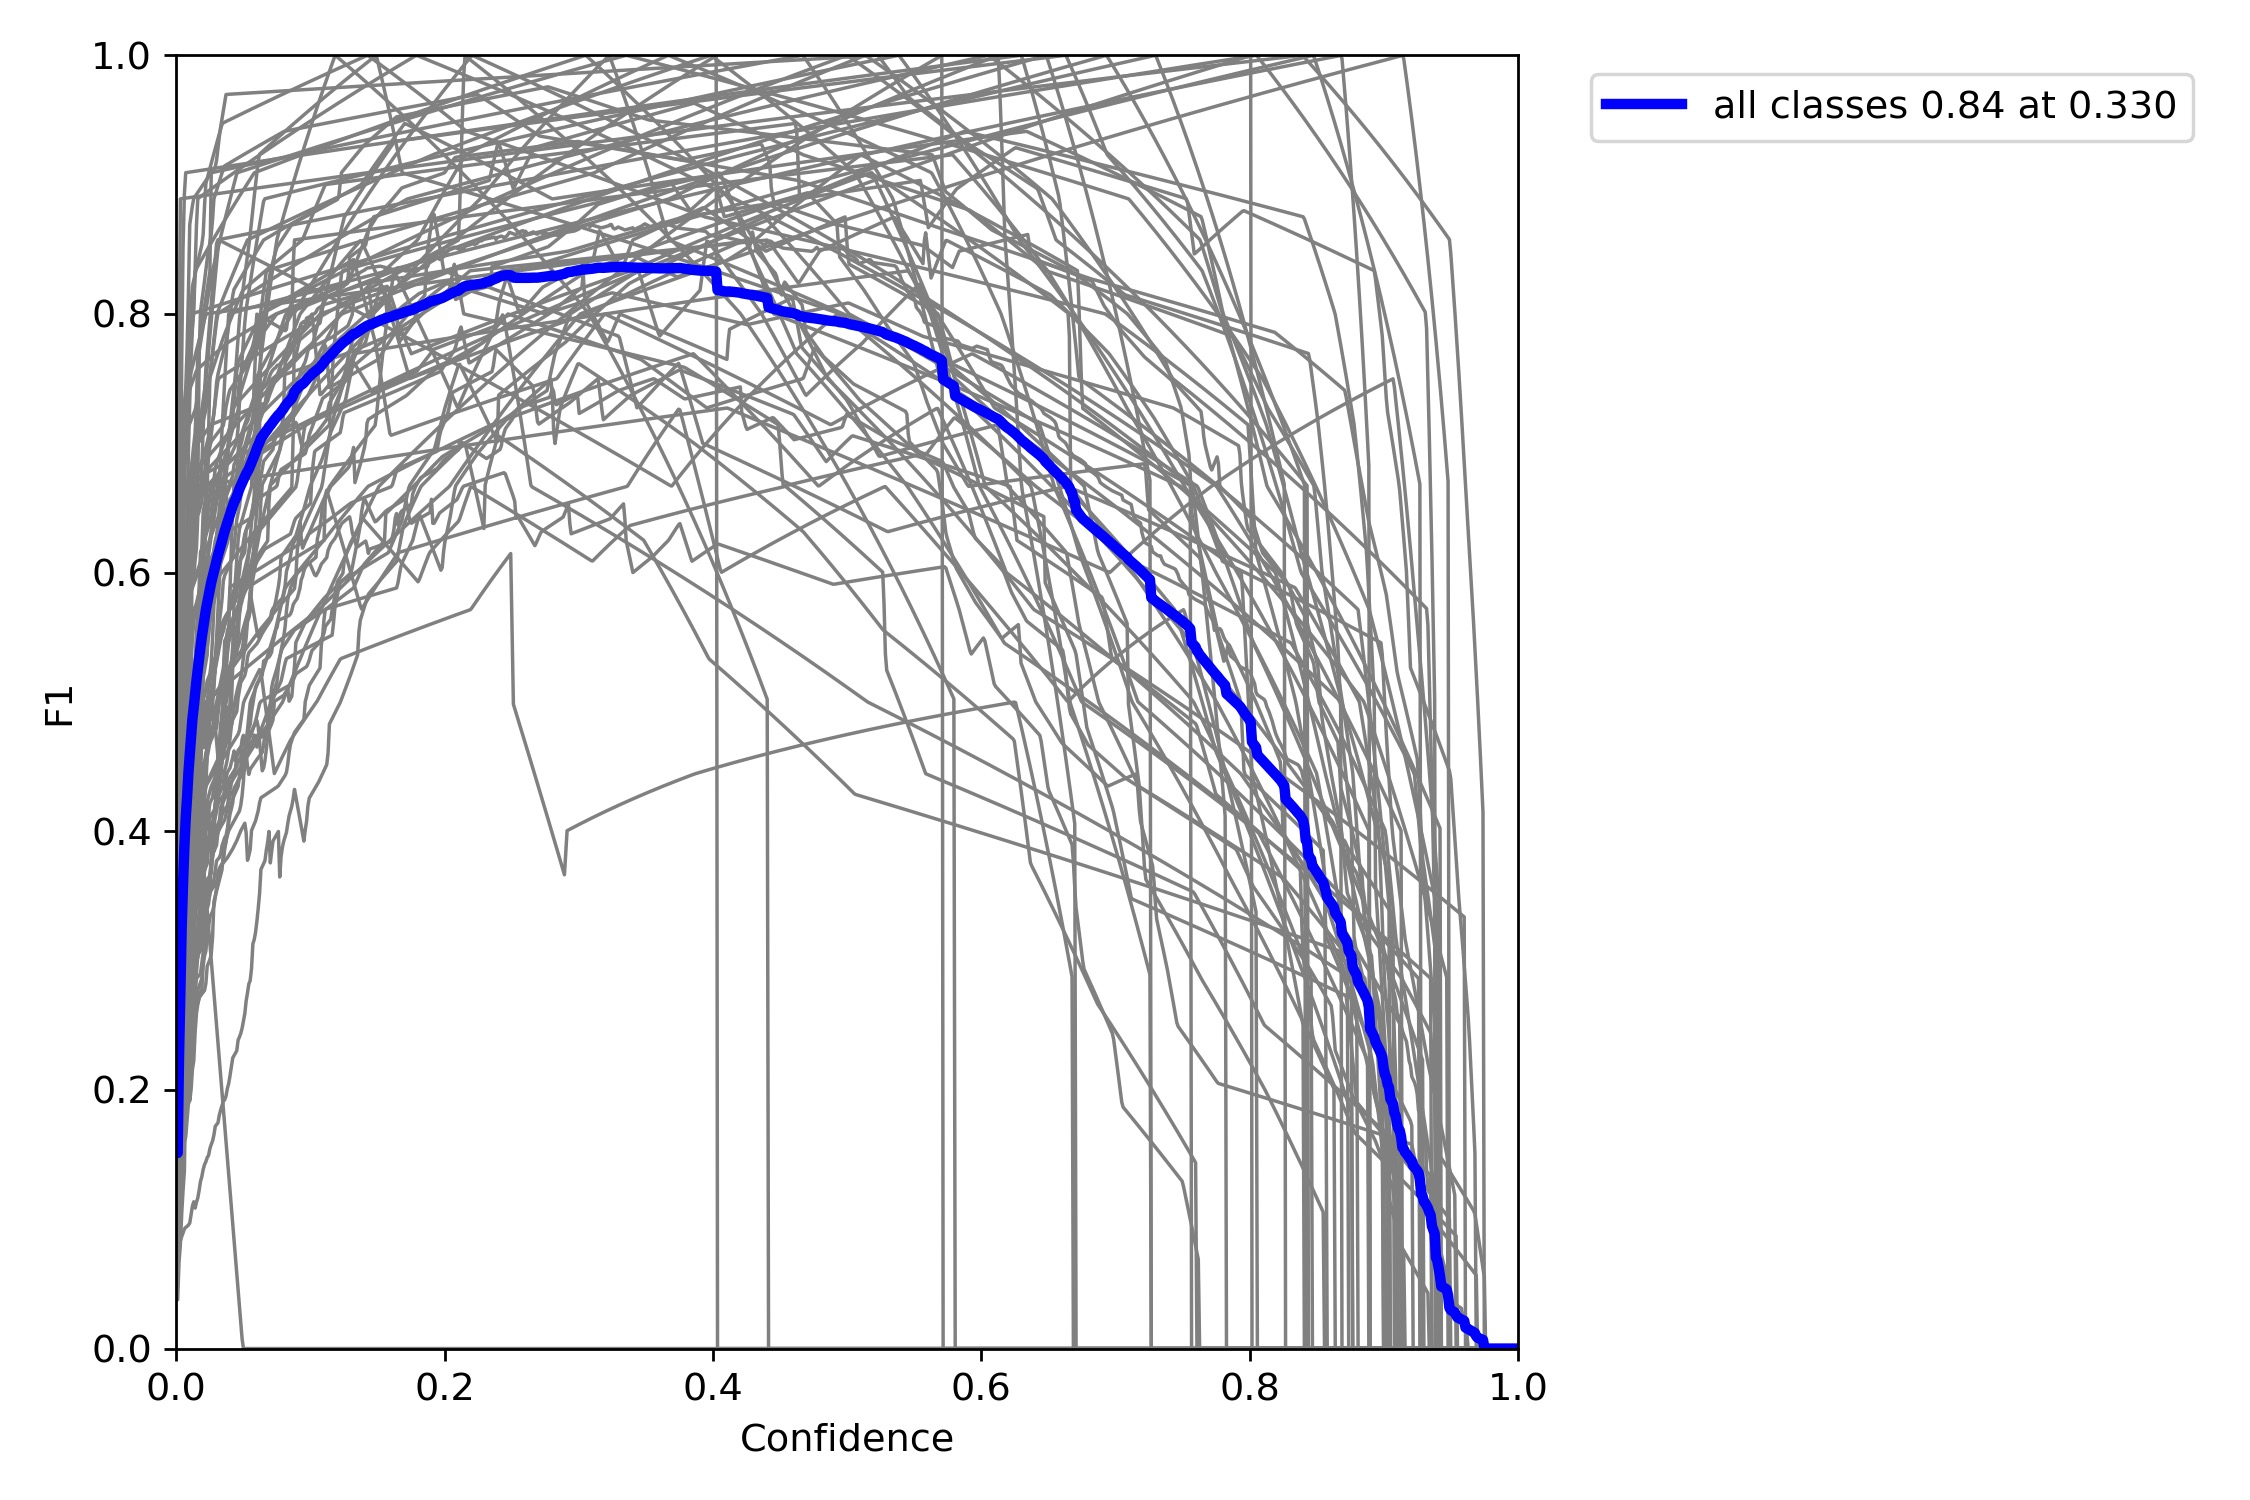

In [12]:
Image('F1.jpg')

## Reference:

**YOLOv3: An Incremental Improvement** https://pjreddie.com/media/files/papers/YOLOv3.pdf

https://github.com/pjreddie

https://github.com/ultralytics/yolov3

https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch

https://github.com/ayooshkathuria/pytorch-yolo-v3

https://github.com/wanghao00/pytorch-yolo-v3/tree/master/002

https://github.com/SpikeKing/keras-yolo3-detection

https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

